<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffustion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-performance image generation using Stable Diffusion in KerasCV



---

## Background

This notebook will implement Stable Diffusion using KerasCV as detailed by the tutorial [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/). Furthermore to fully understand the different components that make up Stable Diffusion I will be using the code snippets of [stable_diffusion](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion) to construct the model step by step.

Stable Diffusion stems from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) a joint project between [Ludwig Maximilian University of Munich & IWR](https://ommer-lab.com/) and [Runway ML](https://runwayml.com/). Stable Diffusion is a form of Multimodal Learning which most people (me and david) consider to be the future of generative learning. As stated in [Generative Deep Learning: Teaching Machines To Paint, Write, Compose, and Play](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=asc_df_1098134184/?tag=hyprod-20&linkCode=df0&hvadid=632163212339&hvpos=&hvnetw=g&hvrand=14059992483304092225&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9006587&hvtargid=pla-1852750701094&psc=1&mcid=e1431dcee2ae37808a9d62e277627154&gclid=Cj0KCQiAkKqsBhC3ARIsAEEjuJj0ac3q0MjvImuQ2N8gFCvcZAO9DwPeKXhdMyDrXfNHztPzxH2kaO4aApI3EALw_wcB):

> Multimodal learning involves training generative models to convert between two or more different kinds of data.Some of the most impressive generative models introduced in the last two years have been multimodal in nature...we will explore how they work in detail and consider *how the future of generative modeling will be shaped by large multimodal models*(emphasis added).

What seperates Stable Diffusion from other text to image multimodal models such as DALL.E and Imagen is that Stable Diffusion wraps an Auto-Encoder architecture over a diffusion model so that the diffusion process takes place in latent space. This allows for significant computational advantages not present in other multimodal models. As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:


> [W]e utilize an autoencoding model which learns a space that is perceptually equivalent to the image space, but offers significantly reduced computational complexity.Such an approach offers several advantages: (i) *By leaving the high-dimensional image space, we obtain DMs which are computationally much more efficient because sampling is performed on a low-dimensional space* (emphasis added).

To train Stable Diffusion from sratch the Autoencoder must first be trained. As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:


> We train all our autoencoder models in an adversarial manner...such that a patch-based discriminator $D_{\Psi }$ is optimized to differentiate original images from reconstructions $D(E(x))$ To avoid arbitrarily scaled latent spaces, we regularize the latent *z* to be zero centered and obtain small
> variance by introducing an regularizing loss term $L_{regularization}$...[t]he full objective to train the autoencoding model (E, D) reads:
\begin{align} L_{Autoencoder}=min_{E,D}max_{\psi}(L_{reconstruction}(x, D(E(x)))-L_{adversarial}(D(E(x)))+logD_{\psi} +L_{regularization}(x;E,D)) \end{align}

After training the Autoencoder from scratch there are different approaches one can take to train a text-conditional latent diffusion model. One approch as detailed in the paper is to jointly train the diffusion model and an unmasked transformer.

As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:

> Based on image-conditioning pairs, we then learn the conditional LDM via $L_{LDM}=\mathbb{E}_{E(x),y,\epsilon\sim N(0,1), t}[\parallel \epsilon-\epsilon_{\theta}(z_t, t, τ_{θ}(y))\parallel^2_2]$ where both $τ_{θ}$ and $\epsilon_{\theta}$ are jointly optimized...[t]his conditioning mechanism is flexible as $τ_{θ}$ can be parameterized with domain-specific experts, e.g. (unmasked) transformers...where y are text prompts

> For text-to-image modeling, we train a 1.45B parameter KL-regularized LDM conditioned on language prompts on [LAION-400M](https://laion.ai/)...[w]e employ the BERT-tokenizer...and implement $τ_{θ}$ as a transformer...to infer a latent code which is mapped into the UNet via (multi-head) cross-attention.

These are some of the hyperparameters used by the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) when training their text-conditional LDM (i.e. Stable Diffusion):

**Hyperparameters of Conditional Latent Diffusion Model:**

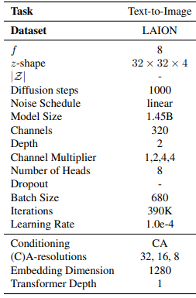

**Hyperparameters of Unmasked Transformer:**

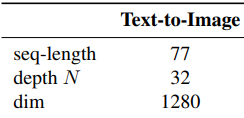










---


## KerasCV Implementation of Stable Diffusion

As by the authors of [Stable-Diffusion-v1-4 ](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion) detail Stable-Diffusion-v1-4 was initialized with the weights of the Stable-Diffusion-v1-2 checkpoint and subsequently fine-tuned on 225k steps at resolution 512x512 on the [laion-aesthetics v2 5+](https://laion.ai/blog/laion-aesthetics/) dataset and 10% dropping of the text-conditioning to improve [classifier-free guidance sampling](https://arxiv.org/abs/2207.12598).

I will not be training the text-conditional LDM (i.e. Stable Diffusion) from sratch but will be loading the pre-trained weights and assembiling the model components that make up [Stable-Diffusion-v1-4 ](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion). These model components  include the following:

*   CLIP based Text Encoder
*   Image Encoder
*   Image Decoder
*   Diffusion Model

In [ ]:
!pip install --upgrade keras-cv-nightly tf-nightly
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_cv

In [3]:
import math
import numpy as np

In [4]:
from keras_cv.src.backend import keras, ops

In [5]:
from keras_cv.src.models.stable_diffusion.padded_conv2d import PaddedConv2D

In [6]:
from keras_cv.src.models.stable_diffusion.attention_block import (  # noqa: E501
    AttentionBlock,
)
from keras_cv.src.models.stable_diffusion.resnet_block import ResnetBlock

In [7]:
from keras_cv.src.backend import random
from keras_cv.src.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.src.models.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.src.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

# CLIP based Text Encoder

In [8]:
class CLIPEmbedding(keras.layers.Layer):
    def __init__(
        self, input_dim=49408, output_dim=768, max_length=77, **kwargs
    ):
        super().__init__(**kwargs)
        self.token_embedding = keras.layers.Embedding(input_dim, output_dim)
        self.position_embedding = keras.layers.Embedding(max_length, output_dim)

    def call(self, inputs):
        tokens, positions = inputs
        tokens = self.token_embedding(tokens)
        positions = self.position_embedding(positions)
        return tokens + positions


class CLIPEncoderLayer(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.clip_attn = CLIPAttention(embed_dim, num_heads, causal=True)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.fc1 = keras.layers.Dense(embed_dim * 4)
        self.fc2 = keras.layers.Dense(embed_dim)
        self.activation = activation

    def call(self, inputs):
        residual = inputs
        x = self.layer_norm1(inputs)
        x = self.clip_attn(x)
        x = residual + x
        residual = x
        x = self.layer_norm2(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x + residual

class CLIPAttention(keras.layers.Layer):
    def __init__(self, embed_dim=768, num_heads=12, causal=True, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.causal = causal
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5
        self.q_proj = keras.layers.Dense(self.embed_dim)
        self.k_proj = keras.layers.Dense(self.embed_dim)
        self.v_proj = keras.layers.Dense(self.embed_dim)
        self.out_proj = keras.layers.Dense(self.embed_dim)

    def reshape_states(self, x, sequence_length, batch_size):
        x = ops.reshape(
            x, (batch_size, sequence_length, self.num_heads, self.head_dim)
        )
        return ops.transpose(
            x, (0, 2, 1, 3)
        )  # bs, heads, sequence_length, head_dim

    def call(self, inputs, attention_mask=None):
        if attention_mask is None and self.causal:
            length = ops.shape(inputs)[1]
            attention_mask = ops.triu(
                ops.ones((1, 1, length, length), dtype=self.compute_dtype)
                * -float("inf"),
                k=1,
            )

        _, tgt_len, embed_dim = inputs.shape
        query_states = self.q_proj(inputs) * self.scale
        key_states = self.reshape_states(self.k_proj(inputs), tgt_len, -1)
        value_states = self.reshape_states(self.v_proj(inputs), tgt_len, -1)

        proj_shape = (-1, tgt_len, self.head_dim)
        query_states = self.reshape_states(query_states, tgt_len, -1)
        query_states = ops.reshape(query_states, proj_shape)
        key_states = ops.reshape(key_states, proj_shape)

        src_len = tgt_len
        value_states = ops.reshape(value_states, proj_shape)
        attn_weights = query_states @ ops.transpose(key_states, (0, 2, 1))

        attn_weights = ops.reshape(
            attn_weights, (-1, self.num_heads, tgt_len, src_len)
        )
        attn_weights = attn_weights + attention_mask
        attn_weights = ops.reshape(attn_weights, (-1, tgt_len, src_len))

        attn_weights = ops.softmax(attn_weights, axis=-1)
        attn_output = attn_weights @ value_states

        attn_output = ops.reshape(
            attn_output, (-1, self.num_heads, tgt_len, self.head_dim)
        )
        attn_output = ops.transpose(attn_output, (0, 2, 1, 3))
        attn_output = ops.reshape(attn_output, (-1, tgt_len, embed_dim))
        return self.out_proj(attn_output)

In [9]:
class TextEncoder(keras.Model):
    def __init__(
        self, max_length, vocab_size=49408, name=None, download_weights=True
    ):
        tokens = keras.layers.Input(
            shape=(max_length,), dtype="int32", name="tokens"
        )
        positions = keras.layers.Input(
            shape=(max_length,), dtype="int32", name="positions"
        )
        x = CLIPEmbedding(vocab_size, 768, max_length)([tokens, positions])
        for _ in range(12):
            x = CLIPEncoderLayer(768, 12, activation=ops.gelu)(x)
        embedded = keras.layers.LayerNormalization(epsilon=1e-5)(x)
        super().__init__([tokens, positions], embedded, name=name)

        if download_weights:
            text_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_encoder.h5",  # noqa: E501
                file_hash="4789e63e07c0e54d6a34a29b45ce81ece27060c499a709d556c7755b42bb0dc4",  # noqa: E501
            )
            self.load_weights(text_encoder_weights_fpath)

In [47]:
text_encoder = TextEncoder(max_length=77)

In [24]:
text_encoder.summary()

Model: "text_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer)       │ (None, 77)             │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ positions (InputLayer)    │ (None, 77)             │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_embedding            │ (None, 77, 768)        │ 38,004,480 │ tokens[0][0],              │
│ (CLIPEmbedding)           │                        │            │ positions[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer        │ (None, 77, 768)        │  7,087,872 │ clip_embedding[0][0]       │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_1      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer[0][0]   │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_2      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_1[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_3      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_2[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_4      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_3[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_5      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_4[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_6      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_5[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_7      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_6[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_8      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_7[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_9      │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_8[0][0] │
│ (CLIPEncoderLayer)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ clip_encoder_layer_10     │ (None, 77, 768)        │  7,087,872 │ clip_encoder_layer_9[0][0] │
│ (CLIPEncoderLayer)   

 Total params: 123,060,480 (469.44 MB)

 Trainable params: 123,060,480 (469.44 MB)

 Non-trainable params: 0 (0.00 B)

# Image Encoder

In [11]:
class ImageEncoder(keras.Sequential):
    """ImageEncoder is the VAE Encoder for StableDiffusion."""

    def __init__(self, download_weights=True):
        super().__init__(
            [
                keras.layers.Input((None, None, 3)),
                PaddedConv2D(128, 3, padding=1),
                ResnetBlock(128),
                ResnetBlock(128),
                PaddedConv2D(128, 3, padding=((0, 1), (0, 1)), strides=2),
                ResnetBlock(256),
                ResnetBlock(256),
                PaddedConv2D(256, 3, padding=((0, 1), (0, 1)), strides=2),
                ResnetBlock(512),
                ResnetBlock(512),
                PaddedConv2D(512, 3, padding=((0, 1), (0, 1)), strides=2),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                AttentionBlock(512),
                ResnetBlock(512),
                keras.layers.GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                PaddedConv2D(8, 3, padding=1),
                PaddedConv2D(8, 1),
                # TODO(lukewood): can this be refactored to be a Rescaling
                #  layer? Perhaps some sort of rescale and gather?
                #  Either way, we may need a lambda to gather the first 4
                #  dimensions.
                keras.layers.Lambda(lambda x: x[..., :4] * 0.18215),
            ]
        )

        if download_weights:
            image_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/vae_encoder.h5",  # noqa: E501
                file_hash="c60fb220a40d090e0f86a6ab4c312d113e115c87c40ff75d11ffcf380aab7ebb",  # noqa: E501
            )
            self.load_weights(image_encoder_weights_fpath)

In [12]:
image_encoder = ImageEncoder()

136824240/136824240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
image_encoder.summary()

Model: "image_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ padded_conv2d (PaddedConv2D)       │ (None, None, None, 128)       │       3,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block (ResnetBlock)         │ (None, None, None, 128)       │     295,680 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_1 (ResnetBlock)       │ (None, None, None, 128)       │     295,680 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_5 (PaddedConv2D)     │ (None, None, None, 128)       │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_2 (ResnetBlock)       │ (None, None, None, 256)       │     919,040 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_3 (ResnetBlock)       │ (None, None, None, 256)       │   1,181,184 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_10 (PaddedConv2D)    │ (None, None, None, 256)       │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_4 (ResnetBlock)       │ (None, None, None, 512)       │   3,673,088 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_5 (ResnetBlock)       │ (None, None, None, 512)       │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_15 (PaddedConv2D)    │ (None, None, None, 512)       │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_6 (ResnetBlock)       │ (None, None, None, 512)       │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_7 (ResnetBlock)       │ (None, None, None, 512)       │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_8 (ResnetBlock)       │ (None, None, None, 512)       │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ attention_block (AttentionBlock)   │ (None, None, None, 512)       │   1,051,648 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_9 (ResnetBlock)       │ (None, None, None, 512)       │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ group_normalization_21             │ (None, None, None, 512)       │       1,024 │
│ (GroupNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ activation (Activation)            │ (None, None, None, 512)       │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_28 (PaddedConv2D)    │ (None, None, None, 8)         │      36,872 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_29 (PaddedConv2D)    │ (None, None, None, 8)         │          72 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lambda (Lambda)                    │ (None, None, None, 4)         │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 34,163,664 (130.32 MB)

 Trainable params: 34,163,664 (130.32 MB)

 Non-trainable params: 0 (0.00 B)

# Image Decoder

In [13]:
class Decoder(keras.Sequential):
    def __init__(self, img_height, img_width, name=None, download_weights=True):
        super().__init__(
            [
                keras.layers.Input((img_height // 8, img_width // 8, 4)),
                keras.layers.Rescaling(1.0 / 0.18215),
                PaddedConv2D(4, 1),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(512),
                AttentionBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                keras.layers.UpSampling2D(2),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                keras.layers.UpSampling2D(2),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(256),
                ResnetBlock(256),
                ResnetBlock(256),
                keras.layers.UpSampling2D(2),
                PaddedConv2D(256, 3, padding=1),
                ResnetBlock(128),
                ResnetBlock(128),
                ResnetBlock(128),
                keras.layers.GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                PaddedConv2D(3, 3, padding=1),
            ],
            name=name,
        )

        if download_weights:
            decoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_decoder.h5",  # noqa: E501
                file_hash="ad350a65cc8bc4a80c8103367e039a3329b4231c2469a1093869a345f55b1962",  # noqa: E501
            )
            self.load_weights(decoder_weights_fpath)

In [14]:
image_decoder = Decoder(img_height=512, img_width=512)

198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [22]:
image_decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ rescaling (Rescaling)              │ (None, 64, 64, 4)             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_32 (PaddedConv2D)    │ (None, 64, 64, 4)             │          20 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_33 (PaddedConv2D)    │ (None, 64, 64, 512)           │      18,944 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_10 (ResnetBlock)      │ (None, 64, 64, 512)           │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ attention_block_1 (AttentionBlock) │ (None, 64, 64, 512)           │   1,051,648 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_11 (ResnetBlock)      │ (None, 64, 64, 512)           │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_12 (ResnetBlock)      │ (None, 64, 64, 512)           │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_13 (ResnetBlock)      │ (None, 64, 64, 512)           │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_14 (ResnetBlock)      │ (None, 64, 64, 512)           │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ up_sampling2d (UpSampling2D)       │ (None, 128, 128, 512)         │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_48 (PaddedConv2D)    │ (None, 128, 128, 512)         │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_15 (ResnetBlock)      │ (None, 128, 128, 512)         │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_16 (ResnetBlock)      │ (None, 128, 128, 512)         │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_17 (ResnetBlock)      │ (None, 128, 128, 512)         │   4,721,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ up_sampling2d_1 (UpSampling2D)     │ (None, 256, 256, 512)         │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_55 (PaddedConv2D)    │ (None, 256, 256, 512)         │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_18 (ResnetBlock)      │ (None, 256, 256, 256)         │   1,902,848 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_19 (ResnetBlock)      │ (None, 256, 256, 256)         │   1,181,184 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_20 (ResnetBlock)      │ (None, 256, 256, 256)         │   1,181,184 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ up_sampling2d_2 (UpSampling2D)     │ (None, 512, 512, 256)         │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ padded_conv2d_62 (PaddedConv2D)    │ (None, 512, 512, 256)         │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet_block_21 (ResnetBlock)      │ (None, 512, 512, 128)         │     476,288 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ res

 Total params: 49,490,199 (188.79 MB)

 Trainable params: 49,490,199 (188.79 MB)

 Non-trainable params: 0 (0.00 B)

# Diffusion Model

In [15]:
class ResBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.entry_flow = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.layers.Activation("swish"),
            PaddedConv2D(output_dim, 3, padding=1),
        ]
        self.embedding_flow = [
            keras.layers.Activation("swish"),
            keras.layers.Dense(output_dim),
        ]
        self.exit_flow = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.layers.Activation("swish"),
            PaddedConv2D(output_dim, 3, padding=1),
        ]

    def build(self, input_shape):
        if input_shape[0][-1] != self.output_dim:
            self.residual_projection = PaddedConv2D(self.output_dim, 1)
        else:
            self.residual_projection = lambda x: x

    def call(self, inputs):
        inputs, embeddings = inputs
        x = inputs
        for layer in self.entry_flow:
            x = layer(x)
        for layer in self.embedding_flow:
            embeddings = layer(embeddings)
        x = x + embeddings[:, None, None]
        for layer in self.exit_flow:
            x = layer(x)
        return x + self.residual_projection(inputs)


class SpatialTransformer(keras.layers.Layer):
    def __init__(self, num_heads, head_size, fully_connected=False, **kwargs):
        super().__init__(**kwargs)
        self.norm = keras.layers.GroupNormalization(epsilon=1e-5)
        channels = num_heads * head_size
        if fully_connected:
            self.proj1 = keras.layers.Dense(num_heads * head_size)
        else:
            self.proj1 = PaddedConv2D(num_heads * head_size, 1)
        self.transformer_block = BasicTransformerBlock(
            channels, num_heads, head_size
        )
        if fully_connected:
            self.proj2 = keras.layers.Dense(channels)
        else:
            self.proj2 = PaddedConv2D(channels, 1)

    def call(self, inputs):
        inputs, context = inputs
        _, h, w, c = inputs.shape
        x = self.norm(inputs)
        x = self.proj1(x)
        x = ops.reshape(x, (-1, h * w, c))
        x = self.transformer_block([x, context])
        x = ops.reshape(x, (-1, h, w, c))
        return self.proj2(x) + inputs


class BasicTransformerBlock(keras.layers.Layer):
    def __init__(self, dim, num_heads, head_size, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn1 = CrossAttention(num_heads, head_size)
        self.norm2 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn2 = CrossAttention(num_heads, head_size)
        self.norm3 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.geglu = GEGLU(dim * 4)
        self.dense = keras.layers.Dense(dim)

    def call(self, inputs):
        inputs, context = inputs
        x = self.attn1(self.norm1(inputs), context=None) + inputs
        x = self.attn2(self.norm2(x), context=context) + x
        return self.dense(self.geglu(self.norm3(x))) + x


class CrossAttention(keras.layers.Layer):
    def __init__(self, num_heads, head_size, **kwargs):
        super().__init__(**kwargs)
        self.to_q = keras.layers.Dense(num_heads * head_size, use_bias=False)
        self.to_k = keras.layers.Dense(num_heads * head_size, use_bias=False)
        self.to_v = keras.layers.Dense(num_heads * head_size, use_bias=False)
        self.scale = head_size**-0.5
        self.num_heads = num_heads
        self.head_size = head_size
        self.out_proj = keras.layers.Dense(num_heads * head_size)

    def call(self, inputs, context=None):
        if context is None:
            context = inputs
        q, k, v = self.to_q(inputs), self.to_k(context), self.to_v(context)
        q = ops.reshape(
            q, (-1, inputs.shape[1], self.num_heads, self.head_size)
        )
        k = ops.reshape(
            k, (-1, context.shape[1], self.num_heads, self.head_size)
        )
        v = ops.reshape(
            v, (-1, context.shape[1], self.num_heads, self.head_size)
        )

        q = ops.transpose(q, (0, 2, 1, 3))  # (bs, num_heads, time, head_size)
        k = ops.transpose(k, (0, 2, 3, 1))  # (bs, num_heads, head_size, time)
        v = ops.transpose(v, (0, 2, 1, 3))  # (bs, num_heads, time, head_size)

        score = td_dot(q, k) * self.scale
        weights = keras.activations.softmax(
            score
        )  # (bs, num_heads, time, time)
        attn = td_dot(weights, v)
        attn = ops.transpose(
            attn, (0, 2, 1, 3)
        )  # (bs, time, num_heads, head_size)
        out = ops.reshape(
            attn, (-1, inputs.shape[1], self.num_heads * self.head_size)
        )
        return self.out_proj(out)


class Upsample(keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.ups = keras.layers.UpSampling2D(2)
        self.conv = PaddedConv2D(channels, 3, padding=1)

    def call(self, inputs):
        return self.conv(self.ups(inputs))


class GEGLU(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.dense = keras.layers.Dense(output_dim * 2)

    def call(self, inputs):
        x = self.dense(inputs)
        x, gate = x[..., : self.output_dim], x[..., self.output_dim :]
        tanh_res = keras.activations.tanh(
            gate * 0.7978845608 * (1 + 0.044715 * (gate**2))
        )
        return x * 0.5 * gate * (1 + tanh_res)


def td_dot(a, b):
    aa = ops.reshape(a, (-1, a.shape[2], a.shape[3]))
    bb = ops.reshape(b, (-1, b.shape[2], b.shape[3]))
    cc = keras.layers.Dot(axes=(2, 1))([aa, bb])
    return ops.reshape(cc, (-1, a.shape[1], cc.shape[1], cc.shape[2]))



class DiffusionModel(keras.Model):
    def __init__(
        self,
        img_height,
        img_width,
        max_text_length,
        name=None,
        download_weights=True,
    ):
        context = keras.layers.Input((max_text_length, 768), name="context")
        t_embed_input = keras.layers.Input((320,), name="timestep_embedding")
        latent = keras.layers.Input(
            (img_height // 8, img_width // 8, 4), name="latent"
        )

        t_emb = keras.layers.Dense(1280)(t_embed_input)
        t_emb = keras.layers.Activation("swish")(t_emb)
        t_emb = keras.layers.Dense(1280)(t_emb)

        # Downsampling flow

        outputs = []
        x = PaddedConv2D(320, kernel_size=3, padding=1)(latent)
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(8, 40, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(320, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(8, 80, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(640, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
            outputs.append(x)
        x = PaddedConv2D(1280, 3, strides=2, padding=1)(x)  # Downsample 2x
        outputs.append(x)

        for _ in range(2):
            x = ResBlock(1280)([x, t_emb])
            outputs.append(x)

        # Middle flow

        x = ResBlock(1280)([x, t_emb])
        x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
        x = ResBlock(1280)([x, t_emb])

        # Upsampling flow

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(1280)([x, t_emb])
            x = SpatialTransformer(8, 160, fully_connected=False)([x, context])
        x = Upsample(1280)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(640)([x, t_emb])
            x = SpatialTransformer(8, 80, fully_connected=False)([x, context])
        x = Upsample(640)(x)

        for _ in range(3):
            x = keras.layers.Concatenate()([x, outputs.pop()])
            x = ResBlock(320)([x, t_emb])
            x = SpatialTransformer(8, 40, fully_connected=False)([x, context])

        # Exit flow

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Activation("swish")(x)
        output = PaddedConv2D(4, kernel_size=3, padding=1)(x)

        super().__init__([latent, t_embed_input, context], output, name=name)

        if download_weights:
            diffusion_model_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_diffusion_model.h5",  # noqa: E501
                file_hash="8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe",  # noqa: E501
            )
            self.load_weights(diffusion_model_weights_fpath)

In [19]:
dm = DiffusionModel(img_height=512, img_width=512, max_text_length=77)

3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [21]:
dm.summary()

Model: "diffusion_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ timestep_embedding        │ (None, 320)            │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_72 (Dense)          │ (None, 1280)           │    410,880 │ timestep_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ latent (InputLayer)       │ (None, 64, 64, 4)      │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ activation_3 (Activation) │ (None, 1280)           │          0 │ dense_72[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ padded_conv2d_112         │ (None, 64, 64, 320)    │     11,840 │ latent[0][0]               │
│ (PaddedConv2D)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_73 (Dense)          │ (None, 1280)           │  1,639,680 │ activation_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ res_block (ResBlock)      │ (None, 64, 64, 320)    │  2,255,040 │ padded_conv2d_112[0][0],   │
│                           │                        │            │ dense_73[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ context (InputLayer)      │ (None, 77, 768)        │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ spatial_transformer       │ (None, 64, 64, 320)    │  2,546,240 │ res_block[0][0],           │
│ (SpatialTransformer)      │                        │            │ context[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ res_block_1 (ResBlock)    │ (None, 64, 64, 320)    │  2,255,040 │ spatial_transformer[0][0], │
│                           │                        │            │ dense_73[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ spatial_transformer_1     │ (None, 64, 64, 320)    │  2,546,240 │ res_block_1[0][0],         │
│ (SpatialTransformer)      │                        │            │ context[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ padded_conv2d_121         │ (None, 32, 32, 320)    │    921,920 │ spatial_transformer_1[0][… │
│ (PaddedConv2D)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ res_block_2 (ResBlock)    │ (None, 32, 32, 640)    │  6,558,080 │ padded_conv2d_121[0][0],   │
│                           │                        │            │ dense_73[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ spatial_transformer_2     │ (None, 32, 32, 640)    │  9,188,480 │ res_block_2[0][0],         │
│ (SpatialTransformer)      │                        │            │ context[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ res_block_3 (ResBlock)    │ (None, 32, 32, 640)    │  8,196,480 │ spatial_transformer_2[0][… │
│                      

 Total params: 859,520,964 (3.20 GB)

 Trainable params: 859,520,964 (3.20 GB)

 Non-trainable params: 0 (0.00 B)

# Assembling the Stable Diffusion Model

In [39]:
MAX_PROMPT_LENGTH=77

class StableDiffusionBase:
    """Base class for stable diffusion and stable diffusion v2 model."""

    def __init__(self,image_encoder,text_encoder,diffusion_model, decoder, tokenizer,img_height=512,img_width=512,jit_compile=False,):
        # UNet requires multiples of 2**7 = 128
        img_height = round(img_height / 128) * 128
        img_width = round(img_width / 128) * 128
        self.img_height = img_height
        self.img_width = img_width

        # lazy initialize the component models and the tokenizer
        self._image_encoder = image_encoder
        self._text_encoder = text_encoder
        self._diffusion_model = diffusion_model
        self._decoder = decoder
        self._tokenizer = tokenizer

        self.jit_compile = jit_compile

    def text_to_image(
        self,
        prompt,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        seed=None,
    ):
        encoded_text = self.encode_text(prompt)

        return self.generate_image(
            encoded_text,
            negative_prompt=negative_prompt,
            batch_size=batch_size,
            num_steps=num_steps,
            unconditional_guidance_scale=unconditional_guidance_scale,
            seed=seed,
        )

    def encode_text(self, prompt):
        """Encodes a prompt into a latent text encoding.

        The encoding produced by this method should be used as the
        `encoded_text` parameter of `StableDiffusion.generate_image`. Encoding
        text separately from generating an image can be used to arbitrarily
        modify the text encoding prior to image generation, e.g. for walking
        between two prompts.

        Args:
            prompt: a string to encode, must be 77 tokens or shorter.

        Example:

        ```python
        from keras_cv.models import StableDiffusion

        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        encoded_text  = model.encode_text("Tacos at dawn")
        img = model.generate_image(encoded_text)
        ```
        """
        # Tokenize prompt (i.e. starting context)
        inputs = self._tokenizer.encode(prompt)
        if len(inputs) > MAX_PROMPT_LENGTH:
            raise ValueError(
                f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)"
            )
        phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))
        phrase = ops.convert_to_tensor([phrase], dtype="int32")

        context = self._text_encoder.predict_on_batch(
            {"tokens": phrase, "positions": self._get_pos_ids()}
        )

        return context

    def generate_image(
        self,
        encoded_text,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        """Generates an image based on encoded text.

        The encoding passed to this method should be derived from
        `StableDiffusion.encode_text`.

        Args:
            encoded_text: Tensor of shape (`batch_size`, 77, 768), or a Tensor
                of shape (77, 768). When the batch axis is omitted, the same
                encoded text will be used to produce every generated image.
            batch_size: int, number of images to generate, defaults to 1.
            negative_prompt: a string containing information to negatively guide
                the image generation (e.g. by removing or altering certain
                aspects of the generated image), defaults to None.
            num_steps: int, number of diffusion steps (controls image quality),
                defaults to 50.
            unconditional_guidance_scale: float, controlling how closely the
                image should adhere to the prompt. Larger values result in more
                closely adhering to the prompt, but will make the image noisier.
                Defaults to 7.5.
            diffusion_noise: Tensor of shape (`batch_size`, img_height // 8,
                img_width // 8, 4), or a Tensor of shape (img_height // 8,
                img_width // 8, 4). Optional custom noise to seed the diffusion
                process. When the batch axis is omitted, the same noise will be
                used to seed diffusion for every generated image.
            seed: integer which is used to seed the random generation of
                diffusion noise, only to be specified if `diffusion_noise` is
                None.

        Example:

        ```python
        from keras_cv.models import StableDiffusion
        from keras_core import ops

        batch_size = 8
        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        e_tacos = model.encode_text("Tacos at dawn")
        e_watermelons = model.encode_text("Watermelons at dusk")

        e_interpolated = ops.linspace(e_tacos, e_watermelons, batch_size)
        images = model.generate_image(e_interpolated, batch_size=batch_size)
        ```
        """
        if diffusion_noise is not None and seed is not None:
            raise ValueError(
                "`diffusion_noise` and `seed` should not both be passed to "
                "`generate_image`. `seed` is only used to generate diffusion "
                "noise when it's not already user-specified."
            )

        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt is None:
            unconditional_context = ops.repeat(
                self._get_unconditional_context(), batch_size, axis=0
            )
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(
                unconditional_context, batch_size
            )

        if diffusion_noise is not None:
            diffusion_noise = ops.squeeze(diffusion_noise)
            if len(ops.shape(diffusion_noise)) == 3:
                diffusion_noise = ops.repeat(
                    ops.expand_dims(diffusion_noise, axis=0), batch_size, axis=0
                )
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)

        # Iterative reverse diffusion stage
        timesteps = np.arange(1, 1000, 1000 // num_steps)
        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)
            unconditional_latent = self._diffusion_model.predict_on_batch(
                {
                    "latent": latent,
                    "timestep_embedding": t_emb,
                    "context": unconditional_context,
                }
            )
            latent = self._diffusion_model.predict_on_batch(
                {
                    "latent": latent,
                    "timestep_embedding": t_emb,
                    "context": context,
                }
            )
            latent = ops.array(
                unconditional_latent
                + unconditional_guidance_scale * (latent - unconditional_latent)
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            # Keras backend array need to cast explicitly
            target_dtype = latent_prev.dtype
            latent = ops.cast(latent, target_dtype)
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(
                a_t
            )
            latent = (
                ops.array(latent) * math.sqrt(1.0 - a_prev)
                + math.sqrt(a_prev) * pred_x0
            )
            iteration += 1
            progbar.update(iteration)

        # Decoding stage
        decoded = self._decoder.predict_on_batch(latent)
        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")

    def _get_unconditional_context(self):
        unconditional_tokens = ops.convert_to_tensor(
            [_UNCONDITIONAL_TOKENS],
            dtype="int32",
        )
        unconditional_context = self._text_encoder.predict_on_batch(
            {"tokens": unconditional_tokens, "positions": self._get_pos_ids()}
        )

        return unconditional_context

    def _expand_tensor(self, text_embedding, batch_size):
        """Extends a tensor by repeating it to fit the shape of the given batch
        size."""
        text_embedding = ops.squeeze(text_embedding)
        if len(text_embedding.shape) == 2:
            text_embedding = ops.repeat(
                ops.expand_dims(text_embedding, axis=0), batch_size, axis=0
            )
        return text_embedding

    @property
    def image_encoder(self):
        """image_encoder returns the VAE Encoder with pretrained weights.

        Usage:
        ```python
        sd = keras_cv.models.StableDiffusion()
        my_image = np.ones((512, 512, 3))
        latent_representation = sd.image_encoder.predict(my_image)
        ```
        """
        if self._image_encoder is None:
            self._image_encoder = ImageEncoder()
            if self.jit_compile:
                self._image_encoder.compile(jit_compile=True)
        return self._image_encoder

    @property
    def text_encoder(self):
        pass

    @property
    def diffusion_model(self):
        pass

    @property
    def decoder(self):
        """decoder returns the diffusion image decoder model with pretrained
        weights. Can be overriden for tasks where the decoder needs to be
        modified.
        """
        if self._decoder is None:
            self._decoder = Decoder(self.img_height, self.img_width)
            if self.jit_compile:
                self._decoder.compile(jit_compile=True)
        return self._decoder

    @property
    def tokenizer(self):
        """tokenizer returns the tokenizer used for text inputs.
        Can be overriden for tasks like textual inversion where the tokenizer
        needs to be modified.
        """
        if self._tokenizer is None:
            self._tokenizer = SimpleTokenizer()
        return self._tokenizer

    def _get_timestep_embedding(
        self, timestep, batch_size, dim=320, max_period=10000
    ):
        half = dim // 2
        range = ops.cast(ops.arange(0, half), "float32")
        freqs = ops.exp(-math.log(max_period) * range / half)
        args = ops.convert_to_tensor([timestep], dtype="float32") * freqs
        embedding = ops.concatenate([ops.cos(args), ops.sin(args)], 0)
        embedding = ops.reshape(embedding, [1, -1])
        return ops.repeat(embedding, batch_size, axis=0)

    def _get_initial_alphas(self, timesteps):
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_initial_diffusion_noise(self, batch_size, seed):
        return random.normal(
            (batch_size, self.img_height // 8, self.img_width // 8, 4),
            seed=seed,
        )

    @staticmethod
    def _get_pos_ids():
        return ops.expand_dims(ops.arange(MAX_PROMPT_LENGTH, dtype="int32"), 0)

In [48]:
model = StableDiffusionBase(image_encoder=image_encoder, text_encoder=text_encoder, diffusion_model=dm, decoder=image_decoder, tokenizer=SimpleTokenizer())

# Generating Images

In [49]:
images = model.text_to_image(prompt="black man sitting outside", batch_size=3)

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 598ms/step


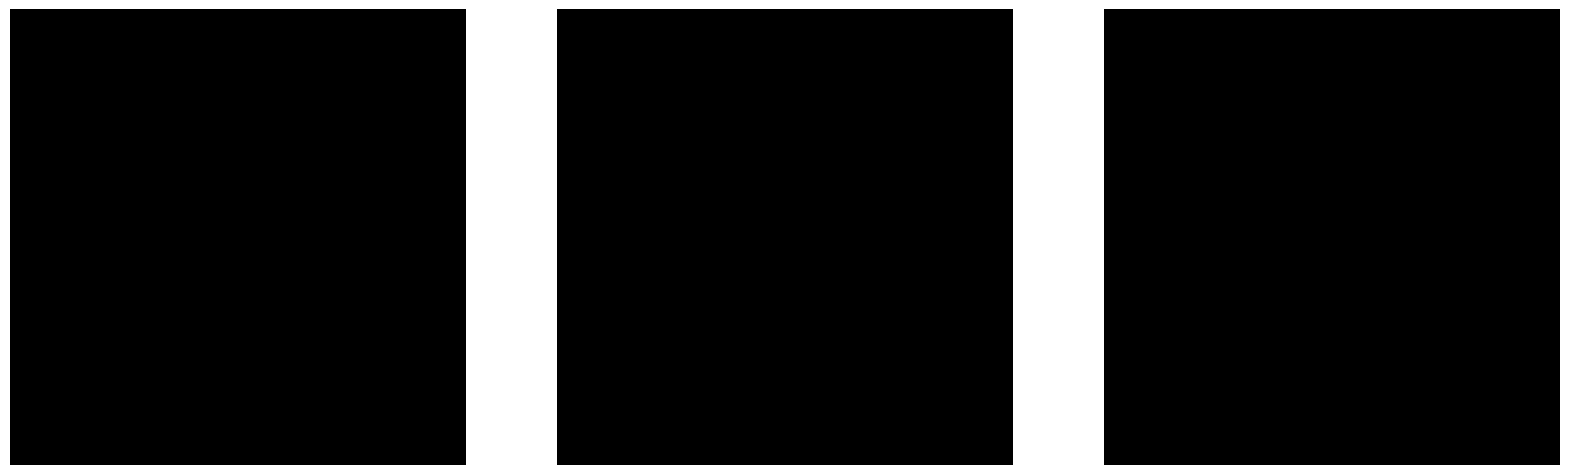

In [50]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)